In [23]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

local_download_path = os.path.expanduser('./')

file_list = drive.ListFile({'q': "title = 'Neural_Nets-demo'"}).GetList()
ignore = ['.ipynb_checkpoints','__pycache__','core','run_','-ubyte.gz']

subdirs = file_list
subdirs[0]['path'] = local_download_path
subdirs[0]['title'] = ''

def retrieve_folder_files(path_to_folder, folder):
  
    files = drive.ListFile({'q': "'"+folder['id']+"' in parents"}).GetList()
    
    try:
      os.makedirs(os.path.join(path_to_folder,folder['title']))
    except: pass
    
    subdirs = []
    
    for file in files:
      
      if all(s not in file['title'] for s in ignore) and all(s not in path_to_folder for s in ignore):
      
        if file['mimeType'][-6:] != 'folder':
          fname = os.path.join(os.path.join(path_to_folder, folder['title']),file['title'])
          print('Getting file:', fname)
          f_ = drive.CreateFile({'id': file['id']})
          f_.GetContentFile(fname)

        else:
          file['path'] = os.path.join(path_to_folder, folder['title'])
          subdirs.append(file)
    
    return(subdirs)

while len(subdirs) > 0:
  
  ssubdirs = []
  
  for folder in subdirs:
    ssubdirs += (retrieve_folder_files(folder['path'], folder))
      
  subdirs = ssubdirs

Getting file: ./load_mnist.py
Getting file: ./Basic_MNIST-keasy.ipynb
Getting file: ./load_mnist.py
Getting file: ./Conv_MNIST.ipynb
Getting file: ./Basic_MNIST.ipynb
Getting file: ./visualization_funcs.py
Getting file: ./pytorch_models/Conv_MNIST-p.ipynb
Getting file: ./pytorch_models/Basic_MNIST-p.ipynb
Getting file: ./tb_models/Conv_MNIST-tb.ipynb
Getting file: ./tb_models/Basic_MNIST-tb.ipynb
Getting file: ./keras_models/Conv_MNIST-k.ipynb
Getting file: ./keras_models/Basic_MNIST-k.ipynb
Getting file: ./logdir/sprite_1024.png
Getting file: ./logdir/labels_1024.tsv


# MNIST Handwritten Digits Classifier

We are going to predict the handwritten digit (from 0 to 9) in an image.

It will use a 1 layer Neural Network.

What we will discuss:
- Data
    - arrays ([Intro to NumPy](https://docs.scipy.org/doc/numpy-dev/user/quickstart.html))
    - data/datasets for ML
- Basic linear algebra ([Intro to lin alg](https://www.youtube.com/playlist?list=PLZHQObOWTQDPD3MizzM2xVFitgF8hE_ab), [Run through of lin alg for ML](http://www.deeplearningbook.org/contents/linear_algebra.html))
    - scalars, vectors, matrices and tensors
    - matrix multiplication
- Neural Networks ([Intro to NNs](https://www.youtube.com/watch?v=ILsA4nyG7I0), [The NN Farm](http://www.asimovinstitute.org/neural-network-zoo/))
    - most basic structure
    - variables
    - training
- Keras Basics ([keras](https://keras.io/))
    - creating a model
    - training a model
    - testing a model

In [0]:
import keras                       # import keras, our machine learning library
import numpy as np                 # import numpy, our linear algebra library
import matplotlib.pyplot as plt    # import matplotlib, our graph plotting library
import visualization_funcs as funcs

### Downloading and extracting data

In [0]:
# get data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


<a id='the_destination'></a>
### What the data is like

The Images:
- 28x28 pixels
- 1 channel valued 0-1 (pixel intensity).
- each image is a matrix

$\left[ \begin{array}{ccc} 
0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.47 & 0.95 & 0.88 & 0.27 & 0.0 \\
0.0 & 0.0 & 0.0 & 0.0 & 0.32 & 0.82 & 0.13 & 0.54 & 0.39 & 0.0 \\
0.0 & 0.0 & 0.0 & 0.0 & 0.61 & 0.15 & 0.36 & 0.73 & 0.0 & 0.0 \\
0.0 & 0.0 & 0.0 & 0.0 & 0.53 & 0.92 & 0.78 & 0.06 & 0.0 & 0.0 \\
0.0 & 0.0 & 0.18 & 0.79 & 0.76 & 0.32 & 0.62 & 0.02 & 0.0 & 0.0 \\
0.0 & 0.0 & 0.46 & 0.51 & 0.01 & 0.14 & 0.81 & 0.05 & 0.0 & 0.0 \\
0.0 & 0.0 & 0.11 & 0.93 & 0.88 & 0.96 & 0.41 & 0.0 & 0.0 & 0.0 \\
0.0 & 0.0 & 0.0 & 0.01 & 0.17 & 0.1 & 0.0 & 0.0 & 0.0 & 0.0 \\
\end{array} \right]$

Classes and Labels:
- 10 classes (0, 1, 2, ..., 9)
- a label contains the class the image is in
- each image is assigned 1 label
- we represent a class with a one-hot encoded vector

$\left[ \begin{array}{ccc} 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \end{array} \right]$

Corresponding values:

$\left[ \begin{array}{ccc} 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 \end{array} \right]$

The index of the 1 valued element, is the value (we can find it using $\arg \max$).

The example vector represent a 2.

In [0]:
image_size = 28         # image dimension size, using square images
num_classes = 10        # number of different digits written

label: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] which is: 4


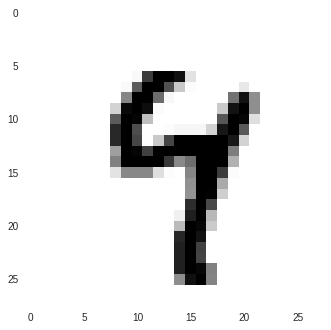

In [0]:
# show example data

# print what number this is
print('label:', mnist.train.labels[2], 'which is:', np.argmax(mnist.train.labels[2]))

# plot the image
plt.imshow(mnist.train.images[2].reshape(image_size,image_size), cmap='binary')
plt.grid(False)
plt.show()

We have split up the data randomly into 3 sets:
- training - to train the model
- validation - to check how the model is training and any hyperparameter adjustments
- testing - once fully trained, used to test accuracy, cannot tune model once tested

We're using data with 55,000 training examples, 5,000 validation and 10,000 testing

Each example has been unstacked and put into 1 row, $28\times28 = 784$

In [0]:
# show data sizes
print('training data shape', mnist.train.images.shape)
print('validation data shape', mnist.validation.images.shape)
print('testing data shape', mnist.test.images.shape)

training data shape (55000, 784)
validation data shape (5000, 784)
testing data shape (10000, 784)


### Hyperparmeters

We need to give values for everything so we can tune them later.

Hyperparams can be about:
- the structure of the Neural Net (# layers, types of layers, # nodes, etc)
- training (number of steps, minimum loss to stop training, learning rate)

In [0]:
batch_size = 100        # number of images fed in to each training step
learning_rate = 0.5     # learning rate
epochs = 2              # number of times we feed in the data set

### Structure

- Define neural network
- Training
    - Forward pass
    - Calculate Loss
    - Back Propagate
- Prediction
    - Forward pass

In [0]:
# reset session
# this is so you dont have to reset kernal and run whole notebook
# you can run from here to give keras and tensorflow a blank canvas
keras.backend.clear_session()

### Forward pass

This is our prediction certainty for each class given our input image.

It will output 10 values, each one a probability (certainty) of the corresponding class.

Below is a diagram:
- each $X$ value is each pixel value in our image
- each $k$ value is our probability of class $k_i$


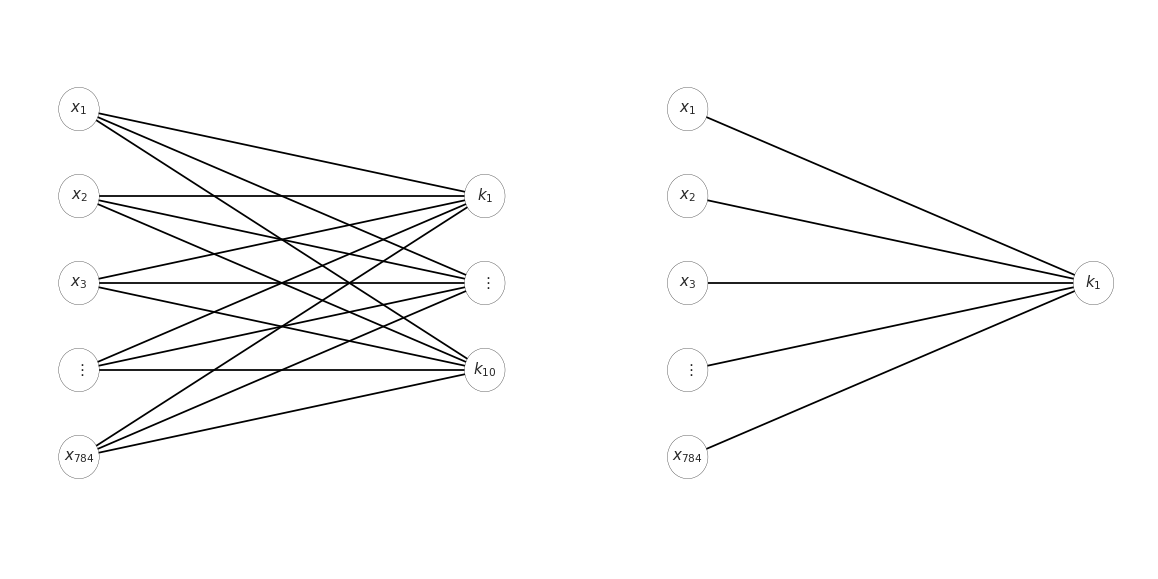

In [0]:
names = [[r'$x_{1}$',r'$x_{2}$',r'$x_{3}$',r'$\vdots$',r'$x_{784}$'],[r'$k_1$',r'$\vdots$',r'$k_{10}$']]
fig,ax = plt.subplots(1, 2,figsize=(20, 10))
ax[0].axis('off')
ax[1].axis('off')
funcs.draw_neural_net(ax[0], .1, .9, .1, .9, [5, 3], names)
funcs.draw_neural_net(ax[1], .1, .9, .1, .9, [5, 1], names)

### Variables (Weights and biases)

These values are the $M$ (Weights) and $c$ (bias) in $y = Mx + c$

The Weights will be multiplied by the input and bias will be added.

We set them as tensorflow Variables so they are adjusted every training step so that $y \approx \hat f(x ; W, b)$

### Implementing the above in keras

All we need to do is add a "Dense" layer
- this is just the name for the type of layer above
- it can also be called a fully connected layer
- it is the most standard layer we use

Keras automatically initiates the weights and biases

We also add a softmax activation function to it
- this normalizes the values so they sum to 1
- it also changes the values using exponentials to give us useful features to train on

In [0]:
# create model
model = keras.models.Sequential()

# a single fully connected layer with softmax activation
# units = number of output values
# input_shape is needed for the first layer so it knows what shape the variables need to be
model.add(keras.layers.Dense(units=num_classes,
                             activation='softmax',
                             input_shape=(image_size**2,)))

# show model structure
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


### Loss

We are using cross entropy.

This computes the difference between the predictions and the labels.
- the labels are one-hot vectors like we said before
- the predictions are probabilities (summing to 1) for each class
- they are the same shape

The loss decreases as the distributions become more similar which is what we want.

### Optimization

We use our optimizer to do this.
- our optimizer is called stochastic gradient descent
- the learning rate is like how sensitive we are when learning
- it performs back-propagation to change the variables

In [0]:
# define loss function
# define optimizer
# also return accuracy as a performance metric
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=learning_rate),
              metrics=['accuracy'])

### Training

We call keras's fit function which trains then nn.

- x is our input training data
- y is our labels corresponding to our training data
- batch size is the number of images we feed in at  each step
- epochs is the number of times we feed in the whole dataset
- verbose just tells it to show current stats
- validataion is the dataset which hasn't been trained on

In [0]:
# train model
history = model.fit(x=mnist.train.images, y=mnist.train.labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(mnist.validation.images, mnist.validation.labels))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 4s 66us/step - loss: 0.4017 - acc: 0.8855 - val_loss: 0.3172 - val_acc: 0.9118
Epoch 2/2
55000/55000 [==============================] - 3s 49us/step - loss: 0.3114 - acc: 0.9116 - val_loss: 0.2843 - val_acc: 0.9226


### Testing

We want to know how well our nn predicts the correct class.

We use keras's evaluate function
- we use a new test dataset which is wasn't trained on
- we find the percentage of images it classified correctly

In [0]:
# show evaluation accuracy
score = model.evaluate(mnist.test.images, mnist.test.labels, verbose=0)
print('Test accuracy:', str(round(100*score[1],2))+'%')

Test accuracy: 92.03%


We can also see how it classifies some examples with the probabilities for each class

prediction: 2 answer: 2
0 0.118%
1 0.001%
2 97.849%
3 0.178%
4 0.0%
5 0.257%
6 1.51%
7 0.0%
8 0.086%
9 0.0%


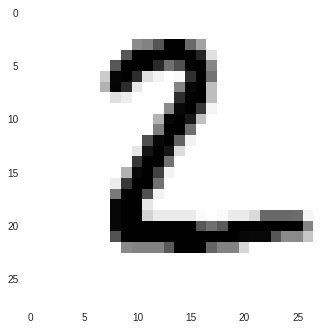

prediction: 1 answer: 1
0 0.001%
1 96.32%
2 1.996%
3 0.318%
4 0.018%
5 0.173%
6 0.293%
7 0.412%
8 0.398%
9 0.071%


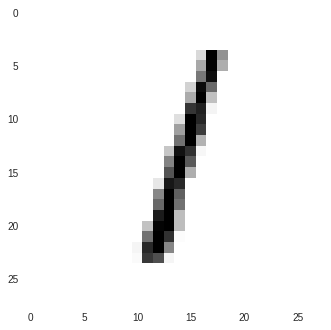

In [0]:
# test and show test images
test_idxs = [1,2]

for test_idx in test_idxs:
    test_x, test_y = mnist.test.images[test_idx].reshape(1,-1), mnist.test.labels[test_idx].reshape(1,-1)

    _prediction = model.predict(test_x)

    print('prediction:', np.argmax(_prediction), 'answer:', np.argmax(test_y))

    for i,val in enumerate(_prediction[0]):
        print(i, str(round((100*val),3))+'%')

    plt.imshow(test_x.reshape(image_size,image_size), cmap='binary')
    plt.grid(False)
    plt.show()

### Visualising the weights

How are the weights predicting the number by multiplication?

Below are the weights for each class in the same shape as the images.

Each pixel in the image and its corresponding weight pixel is multiplied.

If the weight pixel has a positive value where the image has a high value, the probability of this class goes up.

If the weight pixel has a negative value where the image has a high value, the probability of this class goes down.

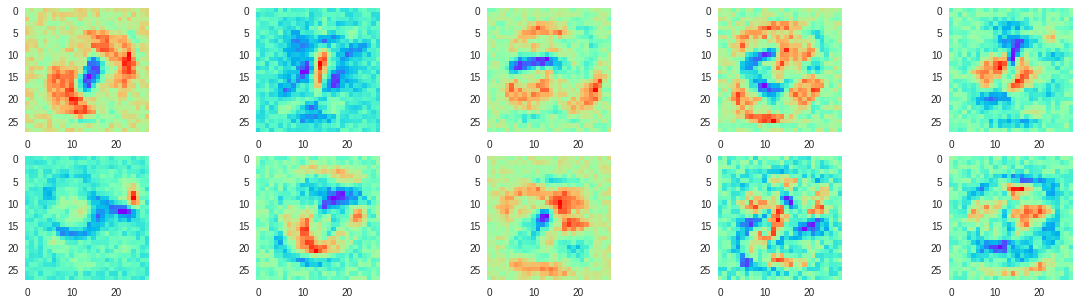

In [0]:
# get our weights
_W = model.get_weights()[0]

fig,ax = plt.subplots(2,5,figsize=(20,5))

for i in range(ax.size):
    # plot each weight vector in the same shape as the images
    ax[i//5,i%5].grid(False)
    ax[i//5,i%5].imshow(_W[:,i].reshape(image_size,image_size), cmap='rainbow')